# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

We acknowledge that we have used AI to the extent permitted by the UVA AI acceptable use policy. The decision to use AI has been mutually agreed upon. We acknowlegde that we are aware of the possibility of AI producing errors and offensive content and certify that we have taken the necessary measures to ensure that the work produced is both accurate and ethical to the best of our ability.

In [2]:
! git clone https://github.com/amn8ge/lab_hedonic_pricing

Cloning into 'lab_hedonic_pricing'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 12 (from 1)
Receiving objects: 100% (16/16), 2.06 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
cd lab_hedonic_pricing

/content/lab_hedonic_pricing


In [4]:
cd data

/content/lab_hedonic_pricing/data


**Question 1**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
housing = pd.read_csv("pierce_county_house_sales.csv")

In [7]:
print(housing.shape)
housing.head()

(16814, 19)


,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,hvac_description,exterior,interior,stories,roof_cover,year_built,bedrooms,bathrooms,waterfront_type,view_quality,utility_sewer
0,2020-01-02,380000,2157,0,0,528,0,0,Warm and Cool Air Zone,Frame Siding,Drywall,2,Composition Shingle,1993,3,3,NaN,NaN,SEWER/SEPTIC INSTALLED
1,2020-01-02,383000,2238,0,0,396,0,0,Forced Air,Frame Siding,Drywall,2,Composition Shingle,2017,4,3,NaN,NaN,SEWER/SEPTIC INSTALLED
2,2020-01-01,419900,1452,0,0,0,0,1,Forced Air,Frame Siding,Drywall,1,Built Up Rock,1965,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED
3,2020-01-02,251660,832,0,0,0,0,0,Forced Air,Frame Vinyl,Drywall,1,Composition Shingle,1919,2,1,NaN,NaN,SEWER/SEPTIC INSTALLED
4,2020-01-02,500000,1780,0,384,484,0,1,Forced Air,Frame Siding,Drywall,1,Composition Shingle,1955,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED


In [8]:
print("Missing values per column:")
print(housing.isnull().sum())

print("\nNumber of duplicate rows:")
print(housing.duplicated().sum())

Missing values per column:
sale_date                          0
sale_price                         0
house_square_feet                  0
attic_finished_square_feet         0
basement_square_feet               0
attached_garage_square_feet        0
detached_garage_square_feet        0
fireplaces                         0
hvac_description                   7
exterior                           1
interior                           7
stories                            0
roof_cover                         8
year_built                         0
bedrooms                           0
bathrooms                          0
waterfront_type                16261
view_quality                   15895
utility_sewer                      0
dtype: int64

Number of duplicate rows:
46


Based on the missing value counts, waterfront_type and view_quality have a large number of missing values, indicating that dropping rows might be necessary. hvac_description, exterior, interior, and roof_cover have a small number of missing values, leading us to believe that they can be dropped without significant data loss. There are also 46 duplicate rows that need to be removed.

In [9]:
# drop columns with many missing values
housing.drop(columns=['waterfront_type', 'view_quality'], inplace=True)

# drop rows with missing values in remaining columns
housing.dropna(inplace=True)

# remove duplicate rows
housing.drop_duplicates(inplace=True)

# remove superfluous column
housing.drop('sale_date', axis=1, inplace=True)

# check data types
print(housing.dtypes)

sale_price                      int64
house_square_feet               int64
attic_finished_square_feet      int64
basement_square_feet            int64
attached_garage_square_feet     int64
detached_garage_square_feet     int64
fireplaces                      int64
hvac_description               object
exterior                       object
interior                       object
stories                         int64
roof_cover                     object
year_built                      int64
bedrooms                        int64
bathrooms                       int64
utility_sewer                  object
dtype: object


In [10]:
# calculate and display descriptive statistics for numerical columns
print("Statistics for numerical columns:")
display(housing.describe())

# identify categorical columns and calculate value counts
categorical_cols = housing.select_dtypes(include='object').columns

print("\nValue counts for categorical columns:")
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(housing[col].value_counts())

# explore the distribution of the target variable 'sale_price'
print("\nDistribution of sale_price:")
print(f"Mean: {housing['sale_price'].mean()}")
print(f"Median: {housing['sale_price'].median()}")
print(f"Standard Deviation: {housing['sale_price'].std()}")
print(f"Minimum: {housing['sale_price'].min()}")
print(f"Maximum: {housing['sale_price'].max()}")

Statistics for numerical columns:


,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,stories,year_built,bedrooms,bathrooms
count,1.675100e+04,16751.00000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000
mean,4.609490e+05,1879.99797,24.970748,168.262731,364.429348,38.389768,0.889977,1.558116,1980.398006,3.278610,2.317294
std,2.342491e+05,759.78104,102.016888,429.499940,286.567819,164.946827,0.596118,0.511432,33.331659,0.887953,0.826811
min,2.000000e+03,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1880.000000,0.000000,0.000000
25%,3.480000e+05,1320.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1959.000000,3.000000,2.000000
50%,4.165000e+05,1774.00000,0.000000,0.000000,421.000000,0.000000,1.000000,2.000000,1990.000000,3.000000,2.000000
75%,5.236180e+05,2351.50000,0.000000,0.000000,528.000000,0.000000,1.000000,2.000000,2006.000000,4.000000,3.000000
max,6.130000e+06,9510.00000,1212.000000,4000.000000,2816.000000,3664.000000,5.000000,3.000000,2021.000000,25.000000,8.000000



Value counts for categorical columns:

Value counts for 'hvac_description':
hvac_description
Forced Air                10342
Electric Baseboard         2660
Heat Pump                  2079
Warm and Cool Air Zone     1267
Floor/Wall Furnace          174
Hot Water Baseboard         146
No Heat                      80
Electric                      2
Floor Wall Furnace            1
Name: count, dtype: int64

Value counts for 'exterior':
exterior
Frame Siding              14527
Frame Vinyl                1719
Masonry Common Brick        208
Frame Stucco                156
Masonry Concrete Block       43
Finished Cottage             38
Frame Rustic Log             21
Log                          12
Frame Hardboard              11
Cedar Finished Cabin          4
Unfinished Cottage            3
Pine Finished Cabin           3
Cedar A-Frame                 2
Cedar Unfinished Cabin        2
Pine A-Frame                  1
Pine Unfinished Cabin         1
Name: count, dtype: int64

Value counts f

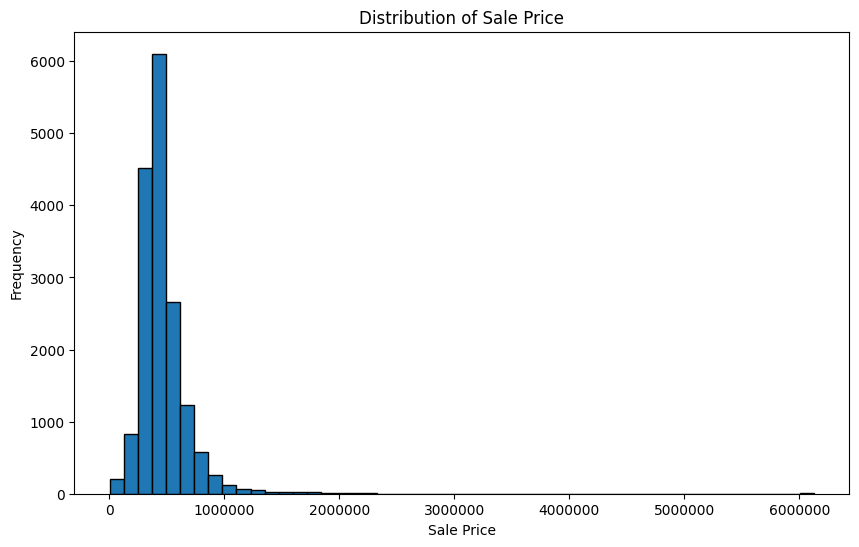

In [11]:
# exploratory graphs
# histogram of 'sale_price'
plt.figure(figsize=(10, 6))
plt.hist(housing['sale_price'], bins=50, edgecolor='black')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Price')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

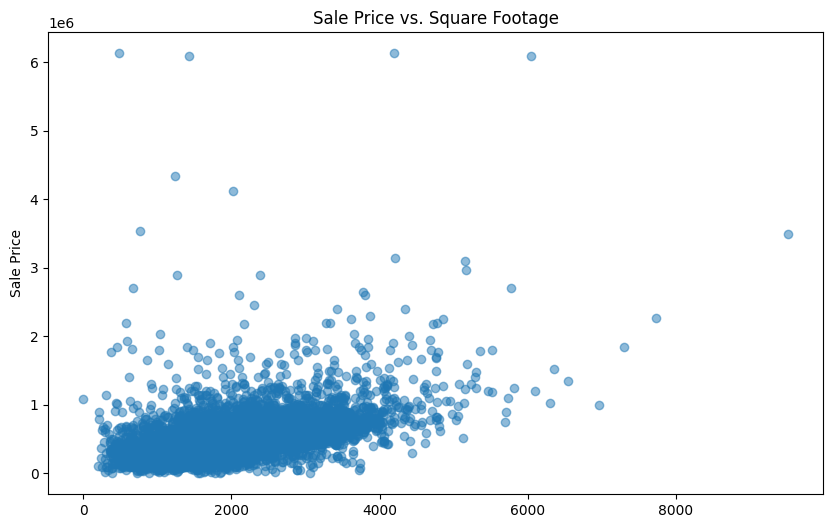

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(housing['house_square_feet'], housing['sale_price'], alpha=0.5)
plt.ylabel('Sale Price')
plt.title(f'Sale Price vs. Square Footage')
plt.show()

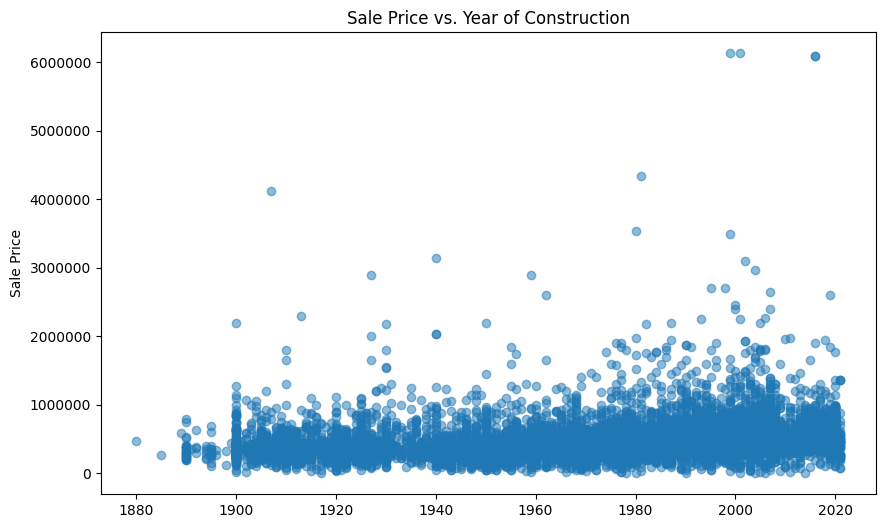

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(housing['year_built'], housing['sale_price'], alpha=0.5)
plt.ylabel('Sale Price')
plt.title(f'Sale Price vs. Year of Construction')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

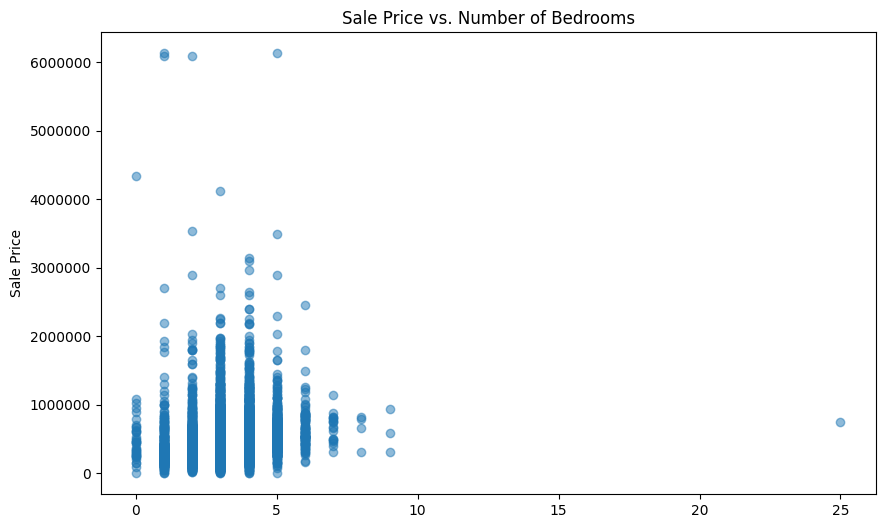

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(housing['bedrooms'], housing['sale_price'], alpha=0.5)
plt.ylabel('Sale Price')
plt.title(f'Sale Price vs. Number of Bedrooms')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

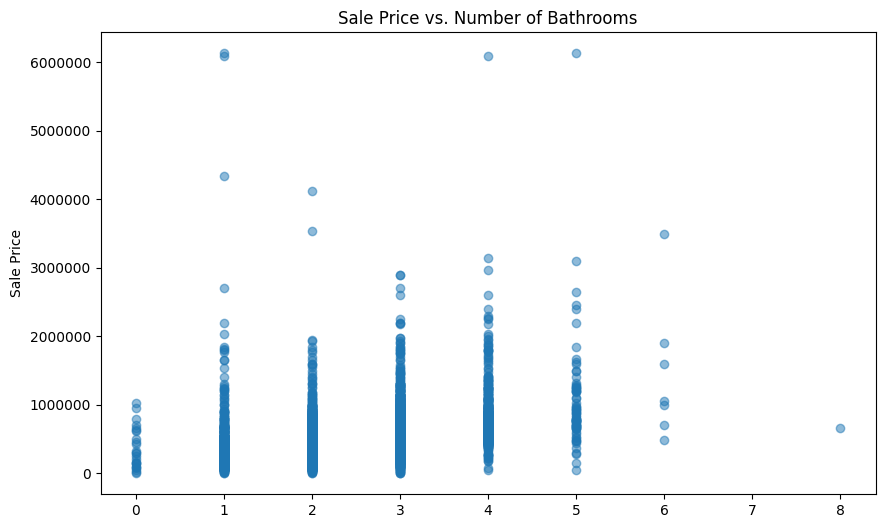

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(housing['bathrooms'], housing['sale_price'], alpha=0.5)
plt.ylabel('Sale Price')
plt.title(f'Sale Price vs. Number of Bathrooms')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

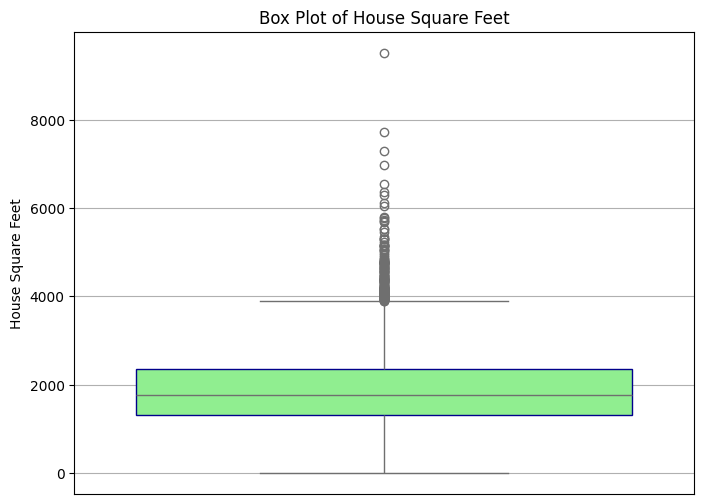

In [16]:
# Box plot for house_square_feet
plt.figure(figsize=(8, 6))
housing.boxplot(column='house_square_feet')
plt.title('Box Plot of House Square Feet')
sns.boxplot(data=housing, y='house_square_feet', color='skyblue', boxprops=dict(facecolor='lightgreen', edgecolor='darkblue'))
plt.ylabel('House Square Feet')
plt.show()

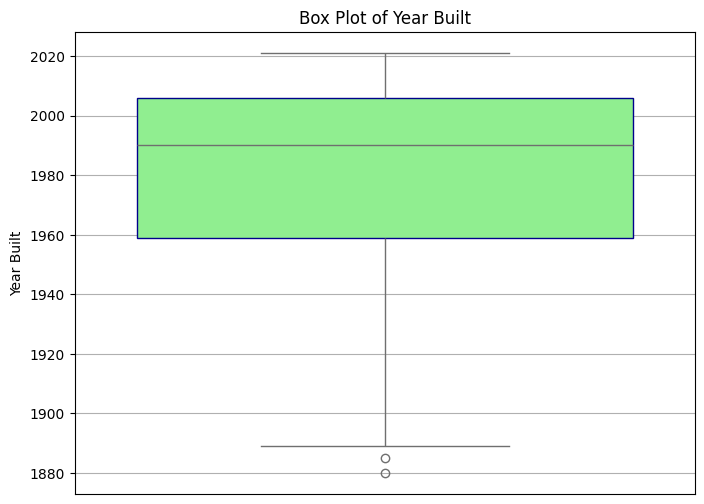

In [17]:
# Box plot for year_built
plt.figure(figsize=(8, 6))
housing.boxplot(column='year_built')
plt.title('Box Plot of Year Built')
plt.ylabel('Year Built')
sns.boxplot(data=housing, y='year_built', color='skyblue', boxprops=dict(facecolor='lightgreen', edgecolor='darkblue'))
plt.show()

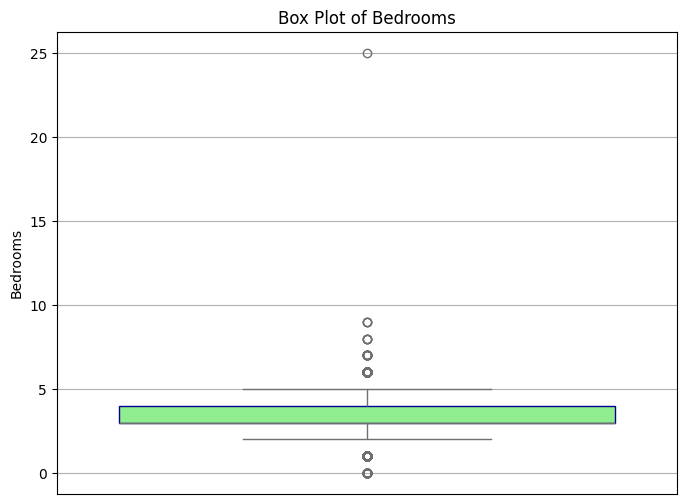

In [18]:
# Box plot for bedrooms
plt.figure(figsize=(8, 6))
housing.boxplot(column='bedrooms')
plt.title('Box Plot of Bedrooms')
sns.boxplot(data=housing, y='bedrooms', color='skyblue', boxprops=dict(facecolor='lightgreen', edgecolor='darkblue'))
plt.ylabel('Bedrooms')
plt.show()

We identified and handled missing values in several columns. waterfront_type and view_quality had a large number of missing values and were dropped. Columns with a small number of missing values (hvac_description, exterior, interior, roof_cover) had those rows dropped.
Duplicate rows were identified and removed.
The sale_date column was dropped as it was deemed superfluous.

The histogram of sale_price showed a right-skewed distribution, indicating that most houses have lower sale prices, with a few outliers having very high prices. Generally, larger houses tend to have higher sale prices, although there is significant variability. There isn't a clear linear relationship between year built and sale price, suggesting that older and newer houses can both command high prices, and other factors are important. While there's a general trend of increasing price with more bedrooms and bathrooms, the relationship is not strictly linear and shows considerable spread.

The categorical variables show varying distributions of different house features.

**Question 2**

In [19]:
# identify categorical columns
categorical_cols_housing = housing.select_dtypes(include='object').columns

# apply one-hot encoding
housing_encoded = pd.get_dummies(housing, columns=categorical_cols_housing, drop_first=True)

**Question 3**

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# train-test split for housing data
housing_train, housing_test = train_test_split(housing_encoded, test_size=0.2, random_state=104)

print("Shape of housing_train:", housing_train.shape)
print("Shape of housing_test:", housing_test.shape)

Shape of housing_train: (13400, 44)
Shape of housing_test: (3351, 44)


**Removing Outliers using IQR**

In [63]:
# Calculate IQR for numerical columns on the training set
numerical_cols = housing_train.select_dtypes(include=np.number).columns.tolist()
# Exclude the target variable 'sale_price' from outlier removal based on its own distribution
numerical_cols.remove('sale_price')

Q1 = housing_train[numerical_cols].quantile(0.25)
Q3 = housing_train[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers based on the training set
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the training set
housing_train_cleaned = housing_train[~((housing_train[numerical_cols] < lower_bound) | (housing_train[numerical_cols] > upper_bound)).any(axis=1)]

# Remove outliers from the test set using bounds calculated from the training set
housing_test_cleaned = housing_test[~((housing_test[numerical_cols] < lower_bound) | (housing_test[numerical_cols] > upper_bound)).any(axis=1)]


print(f"Shape of the original training data: {housing_train.shape}")
print(f"Shape of the training data after removing outliers: {housing_train_cleaned.shape}")
print(f"Shape of the original test data: {housing_test.shape}")
print(f"Shape of the test data after removing outliers: {housing_test_cleaned.shape}")

Shape of the original training data: (13400, 44)
Shape of the training data after removing outliers: (6773, 44)
Shape of the original test data: (3351, 44)
Shape of the test data after removing outliers: (1774, 44)


**Question 4**
Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and on the both the training and test sets. Which of your models does the best?

In [66]:
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Define features and target
features = ['house_square_feet', 'attic_finished_square_feet', 'basement_square_feet',
            'attached_garage_square_feet', 'detached_garage_square_feet', 'fireplaces',
            'stories', 'year_built', 'bedrooms', 'bathrooms']
target = 'sale_price'

# Use the cleaned data after outlier removal
X_train = housing_train_cleaned[features]
y_train = housing_train_cleaned[target]

X_test = housing_test_cleaned[features]
y_test = housing_test_cleaned[target]

# Model 1: house_square_feet only
model1 = sm.OLS(y_train, sm.add_constant(X_train[['house_square_feet']])).fit()
y_train_pred1 = model1.predict(sm.add_constant(X_train[['house_square_feet']]))
y_test_pred1 = model1.predict(sm.add_constant(X_test[['house_square_feet']]))

rmse_train1 = np.sqrt(mean_squared_error(y_train, y_train_pred1))
rmse_test1 = np.sqrt(mean_squared_error(y_test, y_test_pred1))
r2_train1 = r2_score(y_train, y_train_pred1)
r2_test1 = r2_score(y_test, y_test_pred1)

# Model 2: house_square_feet, bedrooms, bathrooms
model2_features = ['house_square_feet', 'bedrooms', 'bathrooms']
model2 = sm.OLS(y_train, sm.add_constant(X_train[model2_features])).fit()
y_train_pred2 = model2.predict(sm.add_constant(X_train[model2_features]))
y_test_pred2 = model2.predict(sm.add_constant(X_test[model2_features]))

rmse_train2 = np.sqrt(mean_squared_error(y_train, y_train_pred2))
rmse_test2 = np.sqrt(mean_squared_error(y_test, y_test_pred2))
r2_train2 = r2_score(y_train, y_train_pred2)
r2_test2 = r2_score(y_test, y_test_pred2)


# Model 3: All numeric features
model3 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_train_pred3 = model3.predict(sm.add_constant(X_train))
y_test_pred3 = model3.predict(sm.add_constant(X_test))

rmse_train3 = np.sqrt(mean_squared_error(y_train, y_train_pred3))
rmse_test3 = np.sqrt(mean_squared_error(y_test, y_test_pred3))
r2_train3 = r2_score(y_train, y_train_pred3)
r2_test3 = r2_score(y_test, y_test_pred3)


# Model 4: All features (numeric and one-hot encoded categorical)
X_train_all = housing_train_cleaned.drop('sale_price', axis=1).astype(int)
X_test_all = housing_test_cleaned.drop('sale_price', axis=1).astype(int)

model4 = sm.OLS(y_train, sm.add_constant(X_train_all)).fit()
y_train_pred4 = model4.predict(sm.add_constant(X_train_all))
y_test_pred4 = model4.predict(sm.add_constant(X_test_all))

rmse_train4 = np.sqrt(mean_squared_error(y_train, y_train_pred4))
rmse_test4 = np.sqrt(mean_squared_error(y_test, y_test_pred4))
r2_train4 = r2_score(y_train, y_train_pred4)
r2_test4 = r2_score(y_test, y_test_pred4)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['1: Size Only', '2: Size + Beds/Baths', '3: All Numeric', '4: All Features'],
    'RMSE_Train': [rmse_train1, rmse_train2, rmse_train3, rmse_train4],
    'RMSE_Test': [rmse_test1, rmse_test2, rmse_test3, rmse_test4],
    'R2_Train': [r2_train1, r2_train2, r2_train3, r2_train4],
    'R2_Test': [r2_test1, r2_test2, r2_test3, r2_test4]
})

display(results)

,Model,RMSE_Train,RMSE_Test,R2_Train,R2_Test
0,1: Size Only,125098.168949,102991.919452,0.333969,0.419601
1,2: Size + Beds/Baths,123353.455939,99540.191013,0.352418,0.457853
2,3: All Numeric,121456.460455,96952.653690,0.372182,0.485673
3,4: All Features,119272.168332,97168.948146,0.394561,0.483375


#Answer

**Question 5**
Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?

/usr/local/lib/python3.12/dist-packages/statsmodels/graphics/regressionplots.py:1199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  focus_val = results.params[focus_col] * model.exog[:, focus_col]


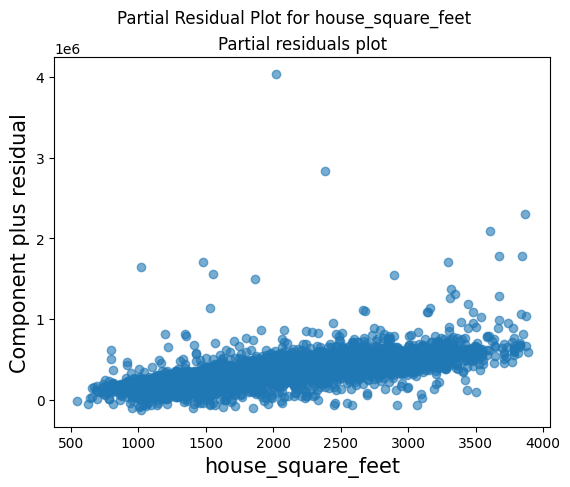

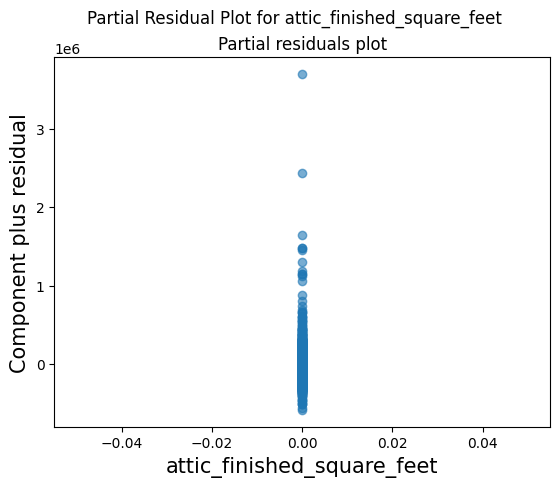

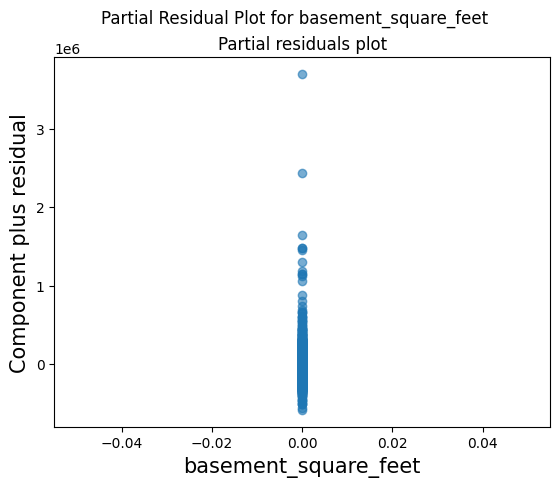

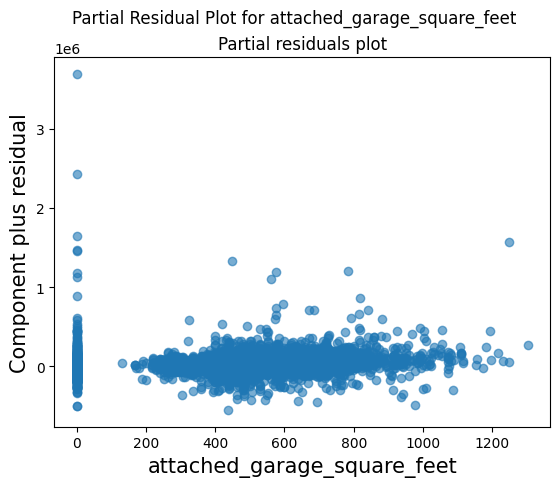

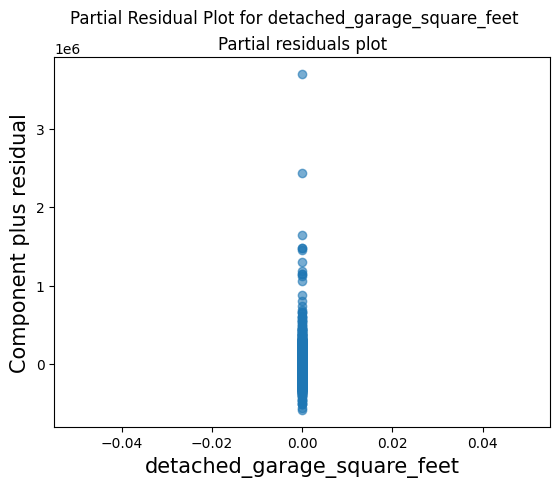

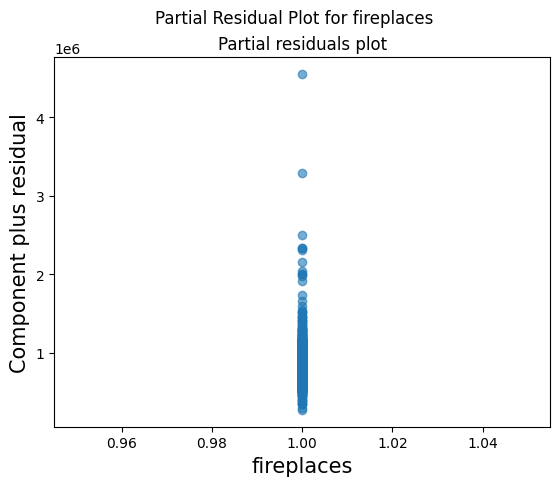

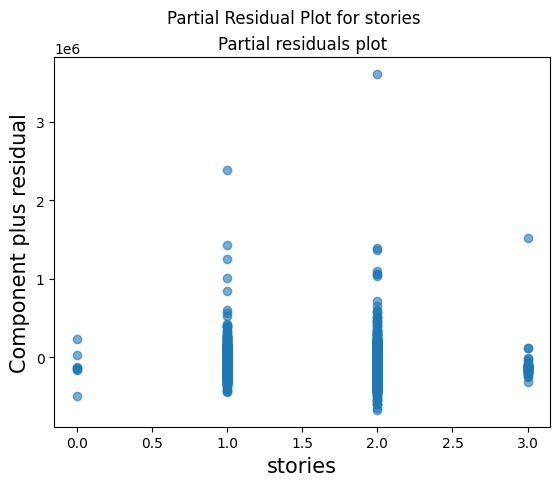

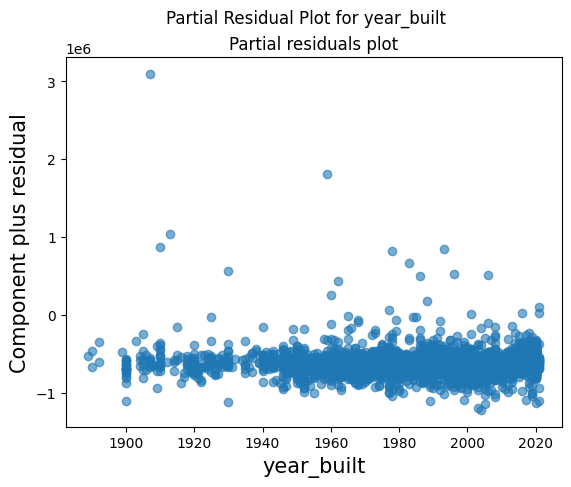

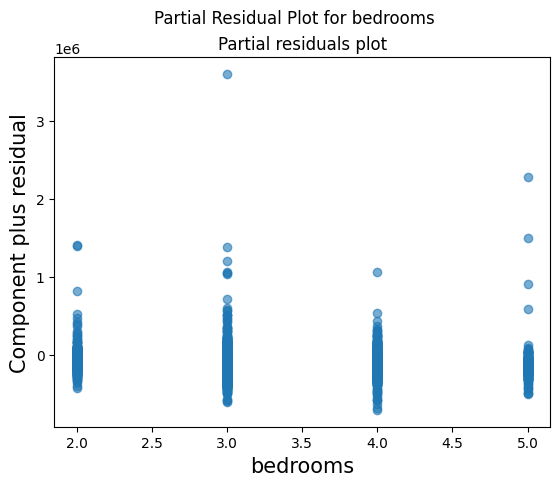

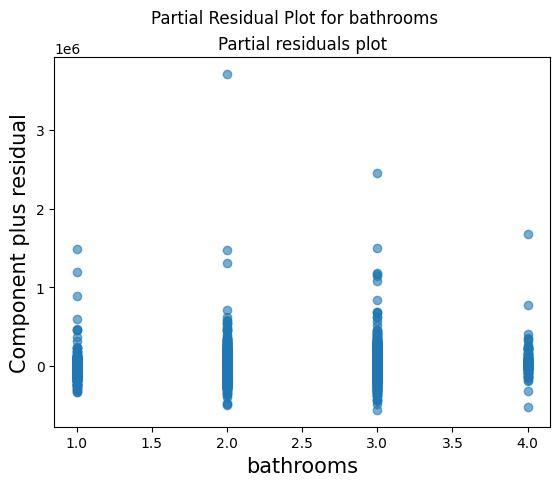

In [67]:
from statsmodels.graphics.regressionplots import plot_partial_residuals

# Define the simple linear model (using all numeric features from the cleaned data)
model_numeric = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Create partial correlation plots for each numeric feature
numeric_features = X_train.columns

for feature in numeric_features:
    fig = plot_partial_residuals(model_numeric, feature)
    fig.suptitle(f'Partial Residual Plot for {feature}')
    plt.show()

#Answer